# Performance

This notebook illustrates performance of typical use cases for bioframe on sets of randomly generated intervals.

In [1]:
# ! pip install pyranges
## Optional:
# ! conda install -c bioconda bedtools
# ! pip install pybedtools

In [2]:
import platform

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import pyranges

import bioframe

plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = 16

# Note that by default we switch off the demo of pybedtools.
# It runs for minutes for 10^5 intervals
include_pybedtools = False
if include_pybedtools:
    import pybedtools

    pybedtools.helpers.set_bedtools_path(
        path="/usr/bin/"
    )  # Set the path to bedtools CLI

In [3]:
print(f"Bioframe v.{bioframe.__version__}")
print(f"PyRanges v.{pyranges.__version__}")
if include_pybedtools:
    print(f"Pybedtools v.{pybedtools.__version__}")

print(f"System Platform: {platform.platform()}")
print(f"{psutil.cpu_count()} CPUs at {psutil.cpu_freq().current:.0f} GHz")

Bioframe v.0.5.1
PyRanges v.0.0.129
System Platform: Linux-5.19.0-46-generic-x86_64-with-glibc2.35
24 CPUs at 3040 GHz


Below we define a function to generate random intervals with various properties, returning a dataframe of intervals.

In [4]:
def make_random_intervals(
    n=1e5,
    n_chroms=1,
    max_coord=None,
    max_length=10,
    sort=False,
    categorical_chroms=False,
):
    n = int(n)
    n_chroms = int(n_chroms)
    max_coord = (n // n_chroms) if max_coord is None else int(max_coord)
    max_length = int(max_length)

    chroms = np.array(["chr" + str(i + 1) for i in range(n_chroms)])[
        np.random.randint(0, n_chroms, n)
    ]
    starts = np.random.randint(0, max_coord, n)
    ends = starts + np.random.randint(1, max_length, n)

    df = pd.DataFrame({"chrom": chroms, "start": starts, "end": ends})

    if categorical_chroms:
        df["chrom"] = df["chrom"].astype("category")

    if sort:
        df = df.sort_values(["chrom", "start", "end"]).reset_index(drop=True)

    return df

## Overlap

In this chapter we characterize the performance of the key function, `bioframe.overlap`. We show that the speed depends on:
- the number of intervals
- number of intersections (or density of intervals)
- type of overlap (inner, outer, left)
- dtype of chromosomes

### vs number of intervals

In [5]:
timings = {}
for n in [1e2, 1e3, 1e4, 1e5, 1e6]:
    df = make_random_intervals(n=n, n_chroms=1)
    df2 = make_random_intervals(n=n, n_chroms=1)
    timings[n] = %timeit -o -r 1 bioframe.overlap(df, df2)

4.92 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
7.13 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
42.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
448 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
6.95 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


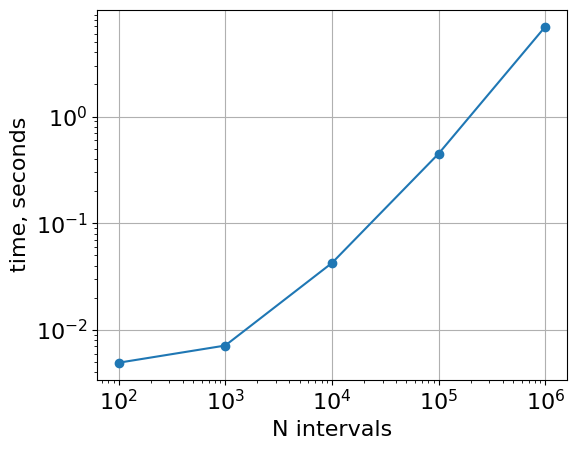

In [6]:
plt.loglog(
    list(timings.keys()),
    list([r.average for r in timings.values()]),
    "o-",
)
plt.xlabel("N intervals")
plt.ylabel("time, seconds")
plt.gca().set_aspect(1.0)
plt.grid()

### vs total number of intersections

Note that not only the number of intervals, but also the density of intervals determines the performance of overlap. 

In [7]:
timings = {}
n_intersections = {}
n = 1e4
for avg_interval_len in [3, 1e1, 3e1, 1e2, 3e2]:
    df = make_random_intervals(n=n, n_chroms=1, max_length=avg_interval_len * 2)
    df2 = make_random_intervals(n=n, n_chroms=1, max_length=avg_interval_len * 2)
    timings[avg_interval_len] = %timeit -o -r 1 bioframe.overlap(df, df2)
    n_intersections[avg_interval_len] = bioframe.overlap(df, df2).shape[0]

22.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
45.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
163 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
611 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.51 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


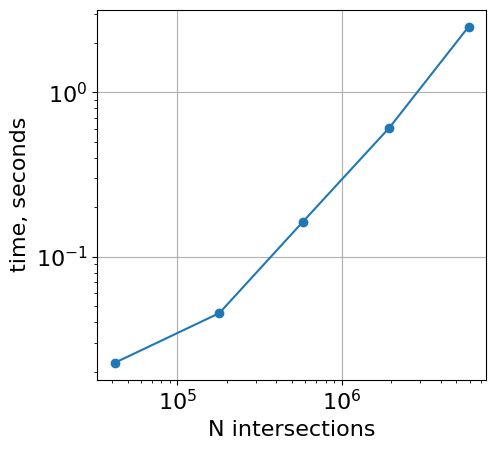

In [8]:
plt.loglog(
    list(n_intersections.values()),
    list([r.average for r in timings.values()]),
    "o-",
)
plt.xlabel("N intersections")
plt.ylabel("time, seconds")
plt.gca().set_aspect(1.0)
plt.grid()

### vs number of chromosomes

If we consider a genome of the same length, divided into more chromosomes, the timing is relatively unaffected.

In [9]:
timings = {}
n_intersections = {}
n = 1e5
for n_chroms in [1, 3, 10, 30, 100, 300, 1000]:
    df = make_random_intervals(n, n_chroms)
    df2 = make_random_intervals(n, n_chroms)
    timings[n_chroms] = %timeit -o -r 1 bioframe.overlap(df, df2)
    n_intersections[n_chroms] = bioframe.overlap(df, df2).shape[0]

443 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
456 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
414 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
434 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
451 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
409 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
443 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Note this test preserves the number of intersections, which is likely why performance remains similar over the considered range.

In [10]:
n_intersections

{1: 810572,
 3: 810871,
 10: 809463,
 30: 815322,
 100: 808166,
 300: 802130,
 1000: 787235}

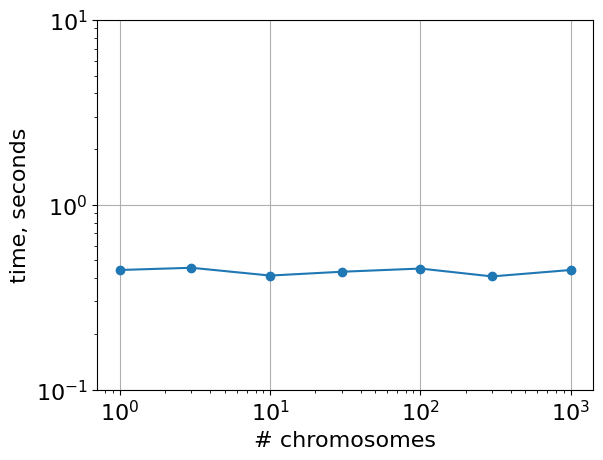

In [11]:
plt.loglog(
    list(timings.keys()),
    list([r.average for r in timings.values()]),
    "o-",
)
plt.ylim([1e-1, 10])
plt.xlabel("# chromosomes")
plt.ylabel("time, seconds")
# plt.gca().set_aspect(1.0)
plt.grid()

### vs other parameters: join type, sorted or categorical inputs

Note that default for overlap: `how='left', keep_order=True`, and the returned dataframe is sorted after the overlaps have been ascertained. Also note that `keep_order=True` is only a valid argument for `how='left'` as the order is not well-defined for inner or outer overlaps. 

In [12]:
df = make_random_intervals()
df2 = make_random_intervals()
%timeit -r 1 bioframe.overlap(df, df2)
%timeit -r 1 bioframe.overlap(df, df2, how='left', keep_order=False)

418 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
274 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [13]:
df = make_random_intervals()
df2 = make_random_intervals()

%timeit -r 1 bioframe.overlap(df, df2, how='outer')
%timeit -r 1 bioframe.overlap(df, df2, how='inner')
%timeit -r 1 bioframe.overlap(df, df2, how='left', keep_order=False)

329 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
151 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
247 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Note below that detection of overlaps takes a relatively small fraction of the execution time. The majority of the time the user-facing function spends on formatting the output table.

In [14]:
df = make_random_intervals()
df2 = make_random_intervals()

%timeit -r 1 bioframe.overlap(df, df2)
%timeit -r 1 bioframe.overlap(df, df2, how='inner')
%timeit -r 1 bioframe.ops._overlap_intidxs(df, df2)
%timeit -r 1 bioframe.ops._overlap_intidxs(df, df2, how='inner')

449 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
148 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
61 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
62.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


Note that sorting inputs provides a moderate speedup, as well as storing chromosomes as categoricals 

In [15]:
print("Default inputs (outer/inner joins):")
df = make_random_intervals()
df2 = make_random_intervals()

%timeit -r 1 bioframe.overlap(df, df2)
%timeit -r 1 bioframe.overlap(df, df2, how='inner')

print("Sorted inputs (outer/inner joins):")
df_sorted = make_random_intervals(sort=True)
df2_sorted = make_random_intervals(sort=True)

%timeit -r 1 bioframe.overlap(df_sorted, df2_sorted)
%timeit -r 1 bioframe.overlap(df_sorted, df2_sorted, how='inner')

print("Categorical chromosomes (outer/inner joins):")
df_cat = make_random_intervals(categorical_chroms=True)
df2_cat = make_random_intervals(categorical_chroms=True)

%timeit -r 1 bioframe.overlap(df_cat, df2_cat)
%timeit -r 1 bioframe.overlap(df_cat, df2_cat, how='inner')

Default inputs (outer/inner joins):
440 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
149 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
Sorted inputs (outer/inner joins):
331 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
137 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
Categorical chromosomes (outer/inner joins):
333 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
90 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


## Vs Pyranges (and, optionally, pybedtools)

### Default arguments

The core intersection function of PyRanges is faster, since PyRanges object splits intervals by chromosomes at the object construction stage

In [16]:
def df2pr(df):
    return pyranges.PyRanges(
        chromosomes=df.chrom,
        starts=df.start,
        ends=df.end,
    )

In [17]:
timings_bf = {}
timings_pr = {}
for n in [1e2, 1e3, 1e4, 1e5, 1e6, 3e6]:
    df = make_random_intervals(n=n, n_chroms=1)
    df2 = make_random_intervals(n=n, n_chroms=1)
    pr = df2pr(df)
    pr2 = df2pr(df2)
    timings_bf[n] = %timeit -o -r 1 bioframe.overlap(df, df2,how='inner')
    timings_pr[n] = %timeit -o -r 1 pr.join(pr2)

2.36 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1.49 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
2.94 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
10.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
6.63 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
128 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
69.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2.35 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.16 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
7.97 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4.75 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


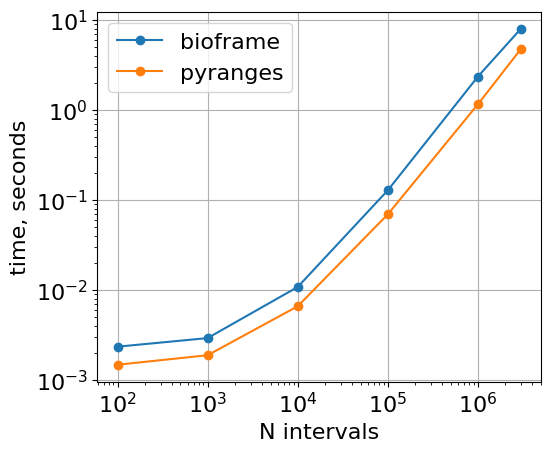

In [18]:
plt.loglog(
    list(timings_bf.keys()),
    list([r.average for r in timings_bf.values()]),
    "o-",
    label="bioframe",
)
plt.loglog(
    list(timings_pr.keys()),
    list([r.average for r in timings_pr.values()]),
    "o-",
    label="pyranges",
)

plt.gca().set(
    xlabel="N intervals",
    ylabel="time, seconds",
    aspect=1.0,
    xticks=10 ** np.arange(2, 6.1),
)
plt.grid()
plt.legend()

### With roundtrips to dataframes

Note that pyranges performs useful calculations at the stage of creating a PyRanges object. Thus a direct comparison for one-off operations on pandas DataFrames between bioframe and pyranges should take this step into account. This roundrip is handled by `pyranges_intersect_dfs` below.

In [19]:
def pyranges_intersect_dfs(df, df2):
    return df2pr(df).intersect(df2pr(df2)).as_df()


if include_pybedtools:

    def pybedtools_intersect_dfs(bed1, bed2):
        return bed1.intersect(bed2).to_dataframe()

In [20]:
timings_bf = {}
timings_pr = {}
if include_pybedtools:
    timings_pb = {}

for n in [1e2, 1e3, 1e4, 1e5, 1e6, 3e6]:
    df = make_random_intervals(n=n, n_chroms=1)
    df2 = make_random_intervals(n=n, n_chroms=1)
    timings_bf[n] = %timeit -o -r 1 bioframe.overlap(df, df2, how='inner')
    timings_pr[n] = %timeit -o -r 1 pyranges_intersect_dfs(df, df2)
    if include_pybedtools:
        bed1 = pybedtools.BedTool.from_dataframe(df)
        bed2 = pybedtools.BedTool.from_dataframe(df2)
        timings_pb[n] = %timeit -o -r 1 pybedtools_intersect_dfs(bed1, bed2)

2.28 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
3.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
3.02 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
4.64 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
11 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
11 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
125 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
87.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2.15 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.44 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
7.98 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
5.23 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


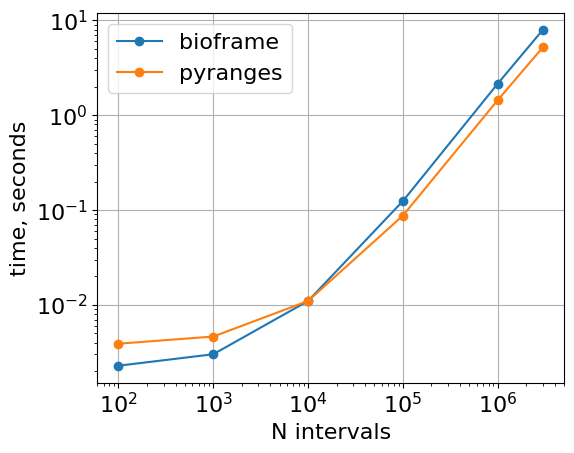

In [21]:
plt.loglog(
    list(timings_bf.keys()),
    list([r.average for r in timings_bf.values()]),
    "o-",
    label="bioframe",
)
plt.loglog(
    list(timings_pr.keys()),
    list([r.average for r in timings_pr.values()]),
    "o-",
    label="pyranges",
)
if include_pybedtools:
    plt.loglog(
        list(timings_pb.keys()),
        list([r.average for r in timings_pb.values()]),
        "o-",
        label="pybedtools",
    )
plt.gca().set(xlabel="N intervals", ylabel="time, seconds", aspect=1.0)
plt.grid()
plt.legend()

### Memory usage

In [23]:
import time

from memory_profiler import memory_usage


def sleep_before_after(func, sleep_sec=0.5):
    """
    Wrapper that allows to report background interpreter's memory consumption
    for the first 5 time intervals (if increment is 0.1 abd sleep_sec=0.5):
    https://github.com/pythonprofilers/memory_profiler#api
    """

    def _f(*args, **kwargs):
        time.sleep(sleep_sec)
        func(*args, **kwargs)
        time.sleep(sleep_sec)

    return _f


mem_usage_bf = {}
mem_usage_pr = {}
if include_pybedtools:
    mem_usage_pb = {}

for n in [1e2, 1e3, 1e4, 1e5, 1e6, 3e6]:
    df = make_random_intervals(n=n, n_chroms=1)
    df2 = make_random_intervals(n=n, n_chroms=1)
    mem_usage_bf[n] = memory_usage(
        (sleep_before_after(bioframe.overlap), (df, df2), dict(how="inner")),
        backend="psutil_pss",
        include_children=True,
        interval=0.1,
    )
    mem_usage_pr[n] = memory_usage(
        (sleep_before_after(pyranges_intersect_dfs), (df, df2), dict()),
        backend="psutil_pss",
        include_children=True,
        interval=0.1,
    )
    if include_pybedtools:
        bed1 = pybedtools.BedTool.from_dataframe(df)
        bed2 = pybedtools.BedTool.from_dataframe(df2)
        mem_usage_pb[n] = memory_usage(
            (sleep_before_after(pybedtools_intersect_dfs), (bed1, bed2), dict()),
            backend="psutil_pss",
            include_children=True,
            interval=0.1,
        )

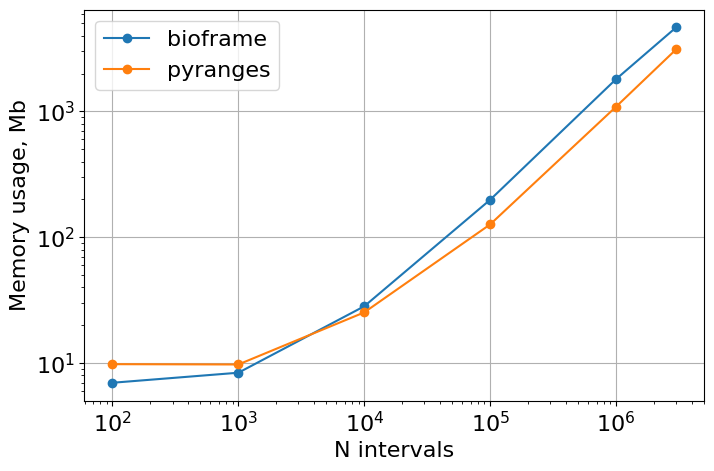

In [24]:
# Note that r[4] is the background memory usage of Python interpreter,
# and max(r) is the maximum memory usage (that must be from the
# bioframe/pyranges functions)
plt.figure(figsize=(8, 6))
plt.loglog(
    list(mem_usage_bf.keys()),
    list([max(r) - r[4] for r in mem_usage_bf.values()]),
    "o-",
    label="bioframe",
)

plt.loglog(
    list(mem_usage_pr.keys()),
    list([max(r) - r[4] for r in mem_usage_pr.values()]),
    "o-",
    label="pyranges",
)

if include_pybedtools:
    plt.loglog(
        list(mem_usage_pb.keys()),
        list([max(r) - r[4] for r in mem_usage_pb.values()]),
        "o-",
        label="pybedtools",
    )

plt.gca().set(xlabel="N intervals", ylabel="Memory usage, Mb", aspect=1.0)
plt.grid()
plt.legend()

In [25]:
print("Bioframe dtypes:")
display(df.dtypes)
print()

print("Pyranges dtypes:")
display(df2pr(df).dtypes)

if include_pybedtools:
    print("Pybedtools dtypes:")
    bed1 = pybedtools.BedTool.from_dataframe(df)
    display(bed1.to_dataframe().dtypes)

Bioframe dtypes:


chrom    object
start     int64
end       int64
dtype: object


Pyranges dtypes:


Chromosome    category
Start            int64
End              int64
dtype: object

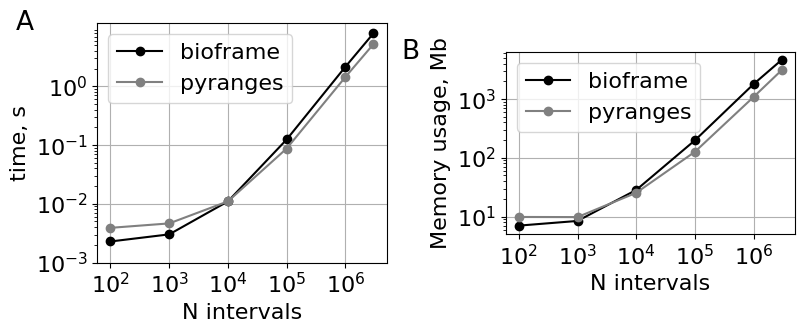

In [26]:
### Combined performance figure.

fig, axs = plt.subplot_mosaic("AAA.BBB", figsize=(9.0, 4))

plt.sca(axs["A"])

plt.text(
    -0.25,
    1.0,
    "A",
    horizontalalignment="center",
    verticalalignment="center",
    transform=plt.gca().transAxes,
    fontsize=19,
)

plt.loglog(
    list(timings_bf.keys()),
    list([r.average for r in timings_bf.values()]),
    "o-",
    color="k",
    label="bioframe",
)
plt.loglog(
    list(timings_pr.keys()),
    list([r.average for r in timings_pr.values()]),
    "o-",
    color="gray",
    label="pyranges",
)
if include_pybedtools:
    plt.loglog(
        list(timings_pb.keys()),
        list([r.average for r in timings_pb.values()]),
        "o-",
        color="lightgray",
        label="pybedtools",
    )

plt.gca().set(
    xlabel="N intervals",
    ylabel="time, s",
    aspect=1.0,
    xticks=10 ** np.arange(2, 6.1),
    yticks=10 ** np.arange(-3, 0.1),
)

plt.grid()
plt.legend()

plt.sca(axs["B"])
plt.text(
    -0.33,
    1.0,
    "B",
    horizontalalignment="center",
    verticalalignment="center",
    transform=plt.gca().transAxes,
    fontsize=19,
)
plt.loglog(
    list(mem_usage_bf.keys()),
    list([max(r) - r[4] for r in mem_usage_bf.values()]),
    "o-",
    color="k",
    label="bioframe",
)

plt.loglog(
    list(mem_usage_pr.keys()),
    list([max(r) - r[4] for r in mem_usage_pr.values()]),
    "o-",
    color="gray",
    label="pyranges",
)
if include_pybedtools:
    plt.loglog(
        list(mem_usage_pb.keys()),
        list([max(r) - r[4] for r in mem_usage_pb.values()]),
        "o-",
        color="lightgray",
        label="pybedtools",
    )

plt.gca().set(
    xlabel="N intervals",
    ylabel="Memory usage, Mb",
    aspect=1.0,
    xticks=10 ** np.arange(2, 6.1),
)

plt.grid()
plt.legend()

### Slicing 

In [27]:
timings_slicing_bf = {}
timings_slicing_pr = {}


for n in [1e2, 1e3, 1e4, 1e5, 1e6, 3e6]:
    df = make_random_intervals(n=n, n_chroms=1)
    timings_slicing_bf[n] = %timeit -o -r 1 bioframe.select(df, ('chr1', n//2, n//4*3))
    pr = df2pr(df)
    timings_slicing_pr[n] = %timeit -o -r 1 pr['chr1', n//2:n//4*3]

334 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
468 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
346 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
593 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
668 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
1.92 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
3.54 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
18.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
40.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
222 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
118 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
804 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


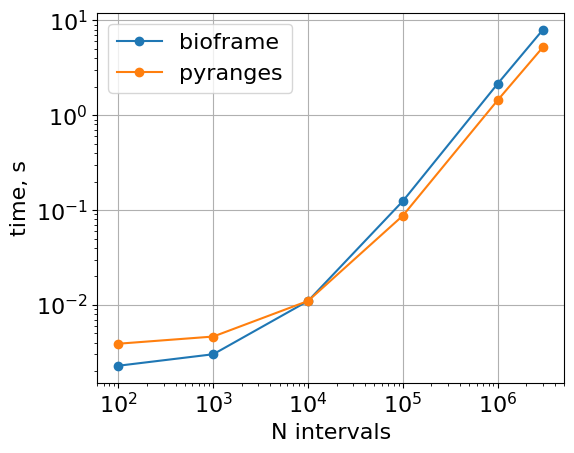

In [28]:
plt.loglog(
    list(timings_slicing_bf.keys()),
    list([r.average for r in timings_bf.values()]),
    "o-",
    label="bioframe",
)

plt.loglog(
    list(timings_slicing_pr.keys()),
    list([r.average for r in timings_pr.values()]),
    "o-",
    label="pyranges",
)
plt.gca().set(xlabel="N intervals", ylabel="time, s", aspect=1.0)
plt.grid()
plt.legend()